# Quadrotor (aka "the drone")

## Example of how to set everything up (do this only once)

Import modules.

In [42]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import secrets
import sympy as sym
import numpy.linalg as la
from scipy import linalg
import ae353_drone

Create and print a seed for the random number generator so it is possible to reproduce the results.

In [43]:
seed = secrets.randbits(32)
print(seed)

3678425235


In [60]:
seed = 992752186

Create simulator with seed.

In [44]:
simulator = ae353_drone.Simulator(
    display=False,
    seed=seed,
)

In [45]:
simulator.set_rules(
    error_on_print=False,    # <-- allow print statements in controller code
    error_on_timeout=False,  # <-- allow long runtimes in controller code
)

In [5]:
params = {
    'm': 0.5,
    'Jx': 0.0023,
    'Jy': 0.0023,
    'Jz': 0.0040,
    'l': 0.175,
    'g': 9.81,
}

# components of position (meters)
p_x, p_y, p_z = sym.symbols('p_x, p_y, p_z')

# yaw, pitch, roll angles (radians)
psi, theta, phi = sym.symbols('psi, theta, phi')

# components of linear velocity (meters / second)
v_x, v_y, v_z = sym.symbols('v_x, v_y, v_z')
v_in_body = sym.Matrix([v_x, v_y, v_z])

# components of angular velocity (radians / second)
w_x, w_y, w_z = sym.symbols('w_x, w_y, w_z')
w_in_body = sym.Matrix([w_x, w_y, w_z])

# components of net rotor torque
tau_x, tau_y, tau_z = sym.symbols('tau_x, tau_y, tau_z')

# net rotor force
f_z = sym.symbols('f_z')

# parameters
m = sym.nsimplify(params['m'])
Jx = sym.nsimplify(params['Jx'])
Jy = sym.nsimplify(params['Jy'])
Jz = sym.nsimplify(params['Jz'])
l = sym.nsimplify(params['l'])
g = sym.nsimplify(params['g'])
J = sym.diag(Jx, Jy, Jz)

# rotation matrices
Rz = sym.Matrix([[sym.cos(psi), -sym.sin(psi), 0], [sym.sin(psi), sym.cos(psi), 0], [0, 0, 1]])
Ry = sym.Matrix([[sym.cos(theta), 0, sym.sin(theta)], [0, 1, 0], [-sym.sin(theta), 0, sym.cos(theta)]])
Rx = sym.Matrix([[1, 0, 0], [0, sym.cos(phi), -sym.sin(phi)], [0, sym.sin(phi), sym.cos(phi)]])
R_body_in_world = Rz @ Ry @ Rx

# angular velocity to angular rates
ex = sym.Matrix([[1], [0], [0]])
ey = sym.Matrix([[0], [1], [0]])
ez = sym.Matrix([[0], [0], [1]])
M = sym.simplify(sym.Matrix.hstack((Ry @ Rx).T @ ez, Rx.T @ ey, ex).inv(), full=True)

# applied forces
f_in_body = R_body_in_world.T @ sym.Matrix([[0], [0], [-m * g]]) + sym.Matrix([[0], [0], [f_z]])

# applied torques
tau_in_body = sym.Matrix([[tau_x], [tau_y], [tau_z]])

# equations of motion
f = sym.Matrix.vstack(
    R_body_in_world * v_in_body,
    M * w_in_body,
    (1 / m) * (f_in_body - w_in_body.cross(m * v_in_body)),
    J.inv() * (tau_in_body - w_in_body.cross(J * w_in_body)),
)

f = sym.simplify(f, full=True)
g = sym.Matrix([p_x, p_y, p_z, psi])
f

Matrix([
[v_x*cos(psi)*cos(theta) + v_y*(sin(phi)*sin(theta)*cos(psi) - sin(psi)*cos(phi)) + v_z*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))],
[v_x*sin(psi)*cos(theta) + v_y*(sin(phi)*sin(psi)*sin(theta) + cos(phi)*cos(psi)) - v_z*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))],
[                                                                      -v_x*sin(theta) + v_y*sin(phi)*cos(theta) + v_z*cos(phi)*cos(theta)],
[                                                                                                 (w_y*sin(phi) + w_z*cos(phi))/cos(theta)],
[                                                                                                              w_y*cos(phi) - w_z*sin(phi)],
[                                                                                  w_x + w_y*sin(phi)*tan(theta) + w_z*cos(phi)*tan(theta)],
[                                                                                                   v_y*w_z - v_z*w_y + 981*sin(theta)/100],
[   

In [6]:
p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze = np.zeros(16)
f_ze = 981/200

all_eq = np.array([p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze])
xe = all_eq[:12].reshape((12,1))
xe

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [7]:
f_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z),f)
g_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z),g)
f_num(p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)
#g_num(p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)


array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [8]:
A_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), f.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))
B_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), f.jacobian([tau_x, tau_y, tau_z, f_z]))
C_num = sym.lambdify((p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z, tau_x, tau_y, tau_z, f_z), g.jacobian([p_x, p_y, p_z, psi, theta, phi, v_x, v_y, v_z, w_x, w_y, w_z]))

A = A_num(p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)
B = B_num(p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)
C = C_num(p_xe, p_ye, p_ze, psie, thetae, phie, v_xe, v_ye, v_ze, w_xe, w_ye, w_ze, tau_xe, tau_ye, tau_ze, f_ze)
A.shape, B.shape, C.shape

((12, 12), (12, 4), (4, 12))

In [9]:
def lqr(A,B,Q,R):
    P=linalg.solve_continuous_are(A,B,Q,R)
    K=linalg.inv(R) @ B.T @ P
    return K

In [12]:
Qc = np.eye(A.shape[0])
Rc = np.eye(B.shape[1])

K = lqr(A,B,Qc,Rc)
K

array([[ 1.26902520e-15, -1.00000000e+00,  1.36308543e-15,
        -3.75294193e-16, -1.40007542e-14,  5.46213218e+00,
        -2.28361367e-15, -1.45381723e+00,  6.10100073e-16,
         1.01248497e+00,  5.03199399e-19,  4.19055367e-16],
       [ 1.00000000e+00,  2.05655837e-15,  1.35854444e-16,
         3.01910506e-14,  5.46213218e+00,  4.56191636e-16,
         1.45381723e+00,  2.16921170e-15,  9.24096718e-17,
         5.03199399e-19,  1.01248497e+00,  1.65064342e-16],
       [ 3.17194233e-14, -1.58542943e-15, -6.58371416e-16,
         1.00000000e+00,  4.58833933e-14,  3.14794144e-15,
         1.79036212e-14, -1.31021569e-15, -3.23989616e-16,
         2.40956836e-16,  9.49119966e-17,  1.00399203e+00],
       [ 4.63671127e-17,  5.11753362e-16,  1.00000000e+00,
        -1.51084614e-16,  2.87264540e-17, -1.23929362e-17,
         6.43198137e-17,  2.91362353e-16,  1.41421356e+00,
         2.80646034e-18,  4.25084490e-19, -2.59191693e-18]])

In [10]:
Qc = np.diag([5.,25.,5.,24.,24.,24.,4.,8.,4.,8.,8.,8.]) 
Rc = np.diag([70.,70.,70.,2.])
K = lqr(A,B,Qc,Rc)

Qo = 100*np.eye(B.shape[1])
Ro = np.eye(A.shape[0])

L = lqr(A.T, C.T, linalg.inv(Ro), linalg.inv(Qo)).T
K, L

(array([[-4.44180698e-16, -5.97614305e-01,  2.98918289e-15,
          6.64410268e-16, -2.20794431e-15,  2.13127925e+00,
         -3.57457364e-16, -6.11519455e-01,  9.34742064e-16,
          3.52263536e-01,  1.98798778e-17, -1.33256130e-17],
        [ 2.67261242e-01, -1.47715138e-15,  4.12542075e-16,
         -1.66516279e-16,  1.73242685e+00,  2.29777433e-15,
          3.89279442e-01, -1.18690446e-15,  3.83385832e-18,
          1.98798778e-17,  3.49649650e-01,  1.54578795e-17],
        [-5.87273816e-16,  2.91085648e-16, -4.52750303e-16,
          5.85540044e-01, -6.27240968e-16, -1.96749066e-16,
         -5.07791694e-16,  3.70035221e-16, -9.69983674e-17,
         -7.66222749e-18,  8.88828072e-18,  3.44920331e-01],
        [-1.07015516e-16, -6.17625337e-15,  1.58113883e+00,
         -1.07825936e-15, -6.22906863e-16,  2.84406109e-14,
         -2.29834542e-16, -9.61411124e-15,  1.89238971e+00,
          1.50493472e-16,  6.17251189e-19, -2.71595429e-17]]),
 array([[ 15.31862643,   0.       

In [14]:
def is_controllable(A,B):
    '''returns controllability matrix W and True/False for controllability of system'''
    n = A.shape[0]
    W = B
    for i in range(1, n):
        col = np.linalg.matrix_power(A, i) @ B
        W = np.block([W, col])
    return W, np.linalg.matrix_rank(W)==W.shape[0]

W = is_controllable(A,B)[0]
is_controllable(A,B)[1] # will return True if controllable

True

In [15]:
def is_observable(A,C):
    n = A.shape[0]
    O = C
    for i in range(1,n):
        row = C@la.matrix_power(A,i)
        O = np.block([[O],[row]])
    return la.matrix_rank(O)==n
is_observable(A,C) # will return True if observable

True

In [16]:
def is_stable(A,L,C):
    F = A-L@C
    eigs = la.eigvals(F)
    return (eigs.real<0).all()

is_stable(A,L,C) # will print True if stable

True

## Example of how to add a drone and run a simulation

Define a controller for the drone.

In [46]:
class Controller:
    def __init__(self):
        self.A = A.astype(float)
        self.B = B.astype(float)
        self.C = C.astype(float)
        self.K = K.astype(float)
        self.L = L.astype(float)  
        self.p_xe = p_xe
        self.p_ye = p_ye
        self.p_ze = p_ze
        
        self.tau_xe = tau_xe
        self.tau_ye = tau_ye
        self.tau_ze = tau_ze
        self.f_ze = f_ze
        self.xe = xe # state equilibrium (constant)
        self.dt = 0.01

    def get_color(self):
        return [0., 1., 0.]

    def reset(
            self,
            p_x_meas, p_y_meas, p_z_meas, # <-- measured position of drone (meters)
            yaw_meas,                     # <-- measured yaw angle of drone (radians)
        ):
        
        self.xhat = np.array([[p_x_meas], [p_y_meas], [p_z_meas], [yaw_meas], [0],[ 0], [0], [0], [0], [0], [0], [0]])

    def run(
            self,
            p_x_meas, p_y_meas, p_z_meas, # <-- measured position of drone (meters)
            yaw_meas,                     # <-- measured yaw angle of drone (radians)
            p_x_ring, p_y_ring, p_z_ring, # <-- center position of next ring (meters)
            is_last_ring,                 # <-- True if next ring is the last ring, False otherwise
            pos_others,                   # <-- 2d array of size n x 3, where n is the number
                                          #     of all *other* drones - the ith row in this array
                                          #     has the coordinates [x_i, y_i, z_i], in meters, of
                                          #     the ith other drone
        ):
        
        
        x_meas = np.block([p_x_meas, p_y_meas, p_z_meas, yaw_meas, np.zeros(8)]).reshape((12,1)) # measured state (partial)
        xhat_des = np.block([p_x_ring, p_y_ring, p_z_ring, np.zeros(9)]).reshape(12,1) # desired state estimate
        
        # Position Tracking
        r = 2.10
        p_hat = self.xhat[0:3]
        p_ring = np.array([p_x_ring, p_y_ring, p_z_ring]).reshape(3, 1)
        p_err = p_ring - p_hat
        
        if(la.norm(p_err)>0.001):
            p_norm = p_err/(linalg.norm(p_err)) 
            p_des = p_hat + r*p_norm

        else:
            p_des = p_ring
        xhat_des[0] = p_des[0]
        xhat_des[1] = p_des[1]
        xhat_des[2] = p_des[2]
        
        # Velocity Tracking
        
        
        
        # Sensor Model
        u_des = np.array([self.tau_xe, self.tau_ye, self.tau_ze, -self.f_ze])
        u = u_des - self.K@(self.xhat - xhat_des)

        u = -self.K@(self.xhat-xhat_des)
        y = (self.C @ (x_meas - self.xe)).reshape(4,1)
        
        tau_x = u[0,0] + self.tau_xe
        tau_y = u[1,0] + self.tau_ye
        tau_z = u[2,0] + self.tau_ze

        if y[2,0] <= 0.5:
            u[3,0] = 2.0
        if is_last_ring: 
            if abs(p_ring[0] - p_x_meas) < 0.79 and abs(p_ring[1] - p_y_meas) < 0.79:
                u[3,0] = -100.
        f_z = u[3,0] + self.f_ze
        u[3,0] = f_z - self.f_ze
        self.xhat += self.dt*((self.A @ self.xhat) + (self.B @ u) - (self.L @ ((self.C @ self.xhat) - y)))

        return tau_x, tau_y, tau_z, f_z

In [47]:
simulator.clear_drones()

Add the drone to the simulator. There are three arguments:

* `Controller` is the class definition
* `'my_netid'` is the name of the drone
* `'my_image.png'` is the name of an image to use as a label (can be `None`, can be a file path)

You can call this function more than once, so long as you call it with a different drone name each time. An exception will be raised if you try to add two drones of the same name to the simulator.

In [48]:
simulator.add_drone(Controller, '1', 'droneface.jpg')

In [49]:
simulator.camera_droneview('1')

Reset the drone (i.e., place it at a random location in the start ring).

In [50]:
simulator.reset()

Run simulation until `max_time` is reached or until the drone reaches the finish ring.

In [51]:
simulator.run(max_time=None)

FINISHED: drone "1" at time 41.75


In [52]:

num_iters = 30
finished = 0
failed = 0
finish_times = np.zeros(num_iters) - np.ones(num_iters)
print("-------Starting Simulations!--------")
for i in range(num_iters):
    simulator.clear_drones()
    simulator.add_drone(Controller, '1', 'droneface.jpg')
    simulator.camera_droneview('1')
    simulator.move_rings()
    simulator.reset()
    x_des_array = []
    simulator.run(max_time=40.0)
    drone_name = '1'
    drone = simulator.get_drone_by_name(drone_name)
    if drone['finish_time'] is None:
        failed += 1
    else:
        finished += 1
        finish_times[i] = drone['finish_time']
    if i%10 == 0:
        print(f"{i} /", num_iters)
print(num_iters, f" /", num_iters)
print("---------Simulations Complete!-------")

-------Starting Simulations!--------
FINISHED: drone "1" at time 30.30
0 / 30
FINISHED: drone "1" at time 30.85
FINISHED: drone "1" at time 29.54
FINISHED: drone "1" at time 23.24
FINISHED: drone "1" at time 27.02
FINISHED: drone "1" at time 25.91
FINISHED: drone "1" at time 24.16
FINISHED: drone "1" at time 26.00
FINISHED: drone "1" at time 30.98
FINISHED: drone "1" at time 28.69
10 / 30
FINISHED: drone "1" at time 26.30
FINISHED: drone "1" at time 22.76
FINISHED: drone "1" at time 25.98
FINISHED: drone "1" at time 25.23
FINISHED: drone "1" at time 29.61
FINISHED: drone "1" at time 28.05
FINISHED: drone "1" at time 26.37
FINISHED: drone "1" at time 23.34
FINISHED: drone "1" at time 26.06
20 / 30
FINISHED: drone "1" at time 26.45
FINISHED: drone "1" at time 25.72
FINISHED: drone "1" at time 25.77
FINISHED: drone "1" at time 29.33
FINISHED: drone "1" at time 25.68
FINISHED: drone "1" at time 26.38
FINISHED: drone "1" at time 23.52
FINISHED: drone "1" at time 24.16
FINISHED: drone "1" at

In [53]:
actual_finish_times = []
for i in range(len(finish_times)):
    if finish_times[i] >= 0:
         actual_finish_times.append(finish_times[i])
actual_finish_times = np.array(actual_finish_times)

------------------Report----------------
Total number of runs:           30
No. of successful runs:         28
No. of failed runs:             2
Success rate:                   93.33333333333333
Mean finish time:               26.714642857142856
Median finish time:             26.18
Standard Deviation:             2.4084783016651485


-----Histogram of all finish times------



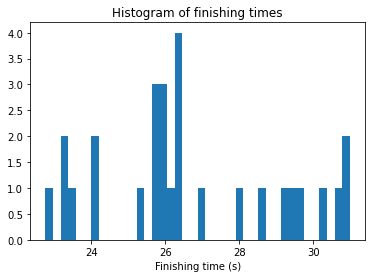

In [54]:
print("------------------Report----------------")
print(f"Total number of runs:          ", num_iters)
print(f"No. of successful runs:        ", finished)
print(f"No. of failed runs:            ", failed)
print(f"Success rate:                  ", finished/num_iters * 100)
print(f"Mean finish time:              ", np.mean(actual_finish_times))
print(f"Median finish time:            ",np.median(actual_finish_times))
print(f"Standard Deviation:            ", np.std(actual_finish_times))
print(f"\n\n-----Histogram of all finish times------\n")
plt.hist(actual_finish_times, bins= 40)
plt.xlabel("Finishing time (s)")
plt.title("Histogram of finishing times")
plt.show()

In [23]:
(
  tau_x,
  tau_y,
  tau_z,
  f_z,
) = simulator.enforce_motor_limits(
-1.4792584209181183, 2.5685045857157376, 7.607654797605395e-14, 9.537152024733434
)
tau_x,tau_y,tau_z, f_z

(-0.9799999999999999,
 0.9799999999999999,
 -4.96707538591831e-18,
 11.479999999999999)

## Example of how to get and plot results

Assume that we already did two things:

* Added a drone with the name `my_netid` to the simulator
* Ran the simulation

Get result.

In [68]:
(
    did_it_fail,
    did_it_finish,
    what_time_did_it_finish,
) = simulator.get_result('1')

Show result.

In [69]:
if did_it_fail:
    print('The drone failed before finishing.')
elif did_it_finish:
    print(f'The drone finished at time {what_time_did_it_finish}')
else:
    print('The drone did not finish (yet).')

The drone did not finish (yet).


Get data.

In [244]:
data = simulator.get_data('1')

In [247]:
data

{'t': array([0.000e+00, 1.000e-02, 2.000e-02, ..., 2.541e+01, 2.542e+01,
        2.543e+01]),
 'p_x': array([-0.80871062, -0.8086916 , -0.80865876, ..., 27.96951201,
        27.98139031, 27.99335219]),
 'p_y': array([ 0.00799449,  0.0080333 ,  0.00805876, ..., -1.09564895,
        -1.08482943, -1.07393204]),
 'p_z': array([0.3       , 0.30025724, 0.30073806, ..., 0.50374404, 0.50248473,
        0.50122499]),
 'yaw': array([-0.00355065, -0.00338597, -0.00311475, ..., -0.01716462,
        -0.01900607, -0.02091688]),
 'pitch': array([0.00639405, 0.02016036, 0.03472809, ..., 0.09350824, 0.10052448,
        0.10772396]),
 'roll': array([ 0.00893391,  0.01456451,  0.02068365, ..., -0.08834308,
        -0.09847632, -0.10850127]),
 'v_x': array([0.00133182, 0.00148064, 0.00198178, ..., 1.17088458, 1.17670026,
        1.18303052]),
 'v_y': array([0.00466646, 0.00398363, 0.00316585, ..., 1.09479216, 1.10249465,
        1.1109352 ]),
 'v_z': array([0.0106891 , 0.03470603, 0.05614568, ..., 0.08022

Plot results.

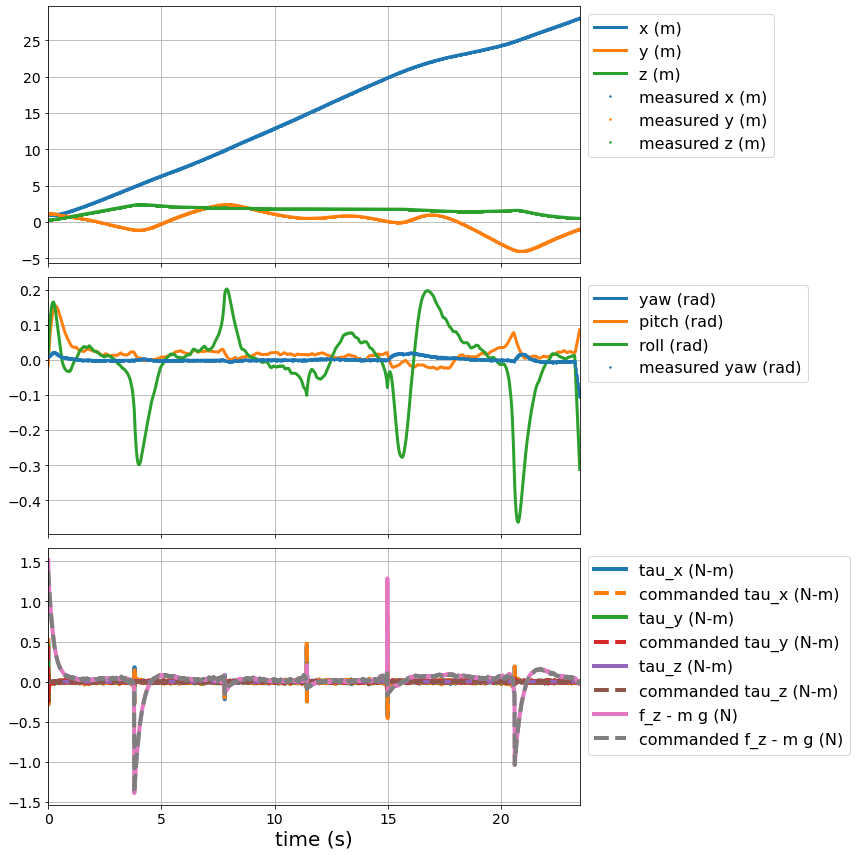

In [128]:
# Create a figure with subplots that all share the same x-axis
fig, (ax_pos, ax_ori, ax_act) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Position
ax_pos.plot(data['t'], data['p_x'], label='x (m)', linewidth=3, color='C0')
ax_pos.plot(data['t'], data['p_y'], label='y (m)', linewidth=3, color='C1')
ax_pos.plot(data['t'], data['p_z'], label='z (m)', linewidth=3, color='C2')
ax_pos.plot(data['t'], data['p_x_meas'], '.', label='measured x (m)', markersize=3, color='C0')
ax_pos.plot(data['t'], data['p_y_meas'], '.', label='measured y (m)', markersize=3, color='C1')
ax_pos.plot(data['t'], data['p_z_meas'], '.', label='measured z (m)', markersize=3, color='C2')
ax_pos.grid()
ax_pos.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_pos.tick_params(labelsize=14)

# Orientation
ax_ori.plot(data['t'], data['yaw'], label='yaw (rad)', linewidth=3)
ax_ori.plot(data['t'], data['pitch'], label='pitch (rad)', linewidth=3)
ax_ori.plot(data['t'], data['roll'], label='roll (rad)', linewidth=3)
ax_ori.plot(data['t'], data['yaw_meas'], '.', label='measured yaw (rad)', markersize=3, color='C0')
ax_ori.grid()
ax_ori.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_ori.tick_params(labelsize=14)

# Actuator commands
ax_act.plot(data['t'], data['tau_x'], label='tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_x_cmd'], '--', label='commanded tau_x (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y'], label='tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_y_cmd'], '--', label='commanded tau_y (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z'], label='tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['tau_z_cmd'], '--', label='commanded tau_z (N-m)', linewidth=4)
ax_act.plot(data['t'], data['f_z'] - (0.5 * 9.81), label='f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.plot(data['t'], data['f_z_cmd'] - (0.5 * 9.81), '--', label='commanded f_z - m g (N)', linewidth=4) # <-- FIXME
ax_act.grid()
ax_act.legend(fontsize=16, bbox_to_anchor=(1., 1.))
ax_act.tick_params(labelsize=14)
# ax_act.set_ylim(-10, 10) # <-- FIXME

# Set shared x-axis properties
ax_act.set_xlabel('time (s)', fontsize=20)
ax_act.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()
plt.show()

Save the figure (without transparent background).

In [129]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Plot histogram of controller run times.

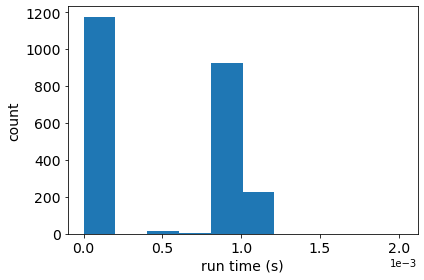

In [130]:
plt.hist(data['run_time'])
plt.ticklabel_format(style='scientific', scilimits=(0, 0), axis='x')
plt.tick_params(labelsize=14)
plt.xlabel('run time (s)', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.tight_layout()
plt.show()

Note that it is required to also plot state estimates (in comparison to states) in order to check that your observer is working - no example is provided here, since no state estimates are being generated by the template `Controller` class.

## Example of how to load drones from the "students" directory

Load drones from `students` directory.

In [31]:
failures = simulator.load_drones()

Try to import controllers from the directory "./students":
 ./students/template.py


The following controllers failed to import and were ignored:



Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation for `max_time` seconds or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to show results, change views, keep running

Show results (so far).

In [131]:
simulator.show_results()

FINISHED
 3                    :  23.47

STILL RUNNING

FAILED


View from behind a particular drone (assuming one exists that is named `template`).

In [ ]:
simulator.camera_droneview('template')

Continue running simulation from same point for `max_time` seconds or until all drones finish.

In [132]:
simulator.run(max_time=5.0)

View from finish ring instead of from start ring.

In [ ]:
simulator.camera_finishview()

Continue running simulation from same point for `max_time` seconds or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

Show results (so far).

In [133]:
simulator.show_results()

FINISHED
 3                    :  23.47

STILL RUNNING

FAILED


## Example of how to clear and reload drones

Clear all drones.

In [ ]:
simulator.clear_drones()

Load drones again from `students` directory.

In [ ]:
simulator.load_drones()

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to rearrange the rings

Rearrange the rings.

In [ ]:
simulator.move_rings()

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

Run simulation until `max_time` is reached or until all drones finish.

In [ ]:
simulator.run(max_time=5.0)

## Example of how to take a snapshot

View from behind a particular drone.

In [ ]:
simulator.camera_droneview('template')

Display a snapshot.

In [ ]:
# Get snapshot as 480 x 480 x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(9, 9))
plt.imshow(rgba)

Save the snapshot.

In [ ]:
plt.imsave('my_snapshot.png', rgba)

## Example of how to record a movie

Reset drones (places drones at random positions within the start ring).

In [ ]:
simulator.reset()

View from behind a particular drone.

In [102]:
simulator.camera_droneview('template')

Exception: drone "template" does not exist

Run simulation until `max_time` is reached or until all drones finish, saving movie to `my_video.mp4`.

In [103]:
simulator.run(max_time=None, video_filename='my_video.mp4')

## Example of how to allow print statements and long run times

By default, your controller will fail if either of the following conditions is met:

* It prints something to `stdout`.
* It exceeds the maximum runtime of `1` second for `init`, `1` second for `reset`, and `5e-3` seconds for `run`.

You can relax these rules for the purpose of development if you want, as follows.

In [ ]:
simulator.set_rules(
    error_on_print=False,    # <-- allow print statements in controller code
    error_on_timeout=False,  # <-- allow long runtimes in controller code
)